<a href="https://colab.research.google.com/github/asdparmeitz/asdparmeitz/blob/main/Sports_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load data into separate dataframes and clean it.
2. Feature engineering and normalization within each dataframe.
3. Merge dataframes into one.
*The fun starts*
4. Correlation analysis; Heatmap, correlation matrix, hierarchical clustering, pca, etc.
5. Baseline model, (random forests?), XGBoost(supported by study). F1 score?
6. Evaluation and plotting of baseline model results.
7. Advanced model: MLP? LSTM?

**Purpose**
- Identify which welness parameters are most important for match performance.
- Can monitoring of these be used to optimize the training for volleyball?


## Data pre-processing and weighting

In [ ]:
!pip install optuna
import pandas as pd
import numpy as np
import os
from functools import reduce
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split, KFold
import warnings



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.5 MB/s eta 0:00:00


Load files, clean data and create dataframes

In [ ]:
# Filepaths
wellness_file         = "/content/anonymized_wellness_file.xlsx"
female_matches_file   = "/content/anonymized_matches_F.xlsx"
wellness_vars         = ["Fatigue", "Sleep", "Doms", "Stress", "Mood", "Tqr"]

**Training Load dataframe**

Does it really makes sense to normalize training load? **Yes**, because the players report perceived training load. So, in theory they will get stronger troughout the season and increment their training. But the training load should "feel" the same since well, they get stronger.

What happens if a player gets injured and returns to training? Perceived training load will increase? (Out of scope for this project)

In [ ]:
# Load data and rename
df_TL = (
    pd.read_excel(wellness_file, sheet_name="Rpe TL F",
                  usecols=["Atleta","Data","TL"])
      .rename(columns={"Atleta":"Athlete","Data":"Date"})
)

df_TL["Athlete"] = df_TL["Athlete"].str.extract(r"([A-Z0-9]{4})")[0].str.upper()
df_TL["Date"]    = pd.to_datetime(df_TL["Date"]).dt.normalize()

# Sum to daily totals, sometimes they train more than once
df_TL = (
    df_TL
      .groupby(["Athlete","Date"], as_index=False)
      .agg(TL=("TL","sum"))
)

# Z-score normalize those daily totals per athlete
df_TL["TL_norm"] = (
    df_TL
      .groupby("Athlete")["TL"]
      .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

# Inspect & save
print(df_TL.head(10))
df_TL.to_excel("df_TL_daily.xlsx", index=False)


  Athlete       Date      TL   TL_norm
0    09RI 2023-09-08   500.0 -0.443978
1    09RI 2023-09-09  1700.0  2.389558
2    09RI 2023-09-11  1300.0  1.445046
3    09RI 2023-09-12   600.0 -0.207850
4    09RI 2023-09-13   480.0 -0.491203
5    09RI 2023-09-14   840.0  0.358857
6    09RI 2023-09-15   525.0 -0.384946
7    09RI 2023-09-16  1147.5  1.084951
8    09RI 2023-09-17   900.0  0.500534
9    09RI 2023-09-19   375.0 -0.739138


**Wellnes dataframe creation**

In [ ]:
df_wellness = (
    pd.read_excel(wellness_file, sheet_name="Wellness F")
      .rename(columns={
          "Atleta":"Athlete",
          "Data":  "Date",
          "Fatica":"Fatigue",
          "Sonno": "Sleep"
      })
)


df_wellness["Athlete"] = (df_wellness["Athlete"].str.extract(r"([A-Z0-9]{4})")[0].str.upper())
df_wellness["Date"] = pd.to_datetime(df_wellness["Date"]).dt.normalize()

def safe_z(x):
    mu = x.mean()
    sigma = x.std(ddof=0)
    if sigma > 0:
        return (x - mu) / sigma
    else:
        return pd.Series(0, index=x.index)

# Apply safe z-score per athlete
df_wellness[wellness_vars] = (
    df_wellness
      .groupby("Athlete")[wellness_vars]
      .transform(safe_z)
)


# Make sure there’s exactly one row per athlete×date
df_wellness = (
    df_wellness
      .groupby(["Athlete","Date"], as_index=False)
      .mean()    # or .first(), depending on how you want to collapse duplicates
)

# Fill NaNs with zero to keep the mean.
df_wellness[wellness_vars] = df_wellness[wellness_vars].fillna(0)


print(df_wellness.head(10))
df_wellness.to_excel("df_wellness.xlsx", index=False)

  Athlete       Date   Fatigue     Sleep      Doms    Stress      Mood  \
0    09RI 2023-09-09 -0.046604 -1.144615  1.482647 -0.674759 -0.779682   
1    09RI 2023-09-10  1.537917 -0.175155  1.482647 -0.674759 -0.779682   
2    09RI 2023-09-11 -1.631124  1.763766 -0.071846 -0.674759 -0.779682   
3    09RI 2023-09-13 -0.046604  1.763766  1.482647 -0.674759  0.417507   
4    09RI 2023-09-14 -0.046604 -0.175155  1.482647 -0.674759 -0.779682   
5    09RI 2023-09-15 -0.046604 -0.175155  1.482647 -0.674759  0.417507   
6    09RI 2023-09-16 -0.046604 -0.175155 -0.071846 -0.674759 -0.779682   
7    09RI 2023-09-17  1.537917  0.794306 -0.071846 -0.674759 -0.779682   
8    09RI 2023-09-18  1.537917  0.794306  1.482647 -0.674759  0.417507   
9    09RI 2023-09-19 -0.046604  0.794306 -1.626340  5.685348  4.009077   

        Tqr  
0  0.611372  
1  0.611372  
2  2.024057  
3  0.611372  
4  0.611372  
5 -0.330418  
6  1.553162  
7 -0.330418  
8 -0.330418  
9 -0.801313  


**Jump dataframe creation**

In [ ]:
df_jumps = (
    pd.read_excel(wellness_file, sheet_name="SALTI_F", usecols=["Atleta","Data","SALTI"])
      .rename(columns={"Atleta":"Athlete","Data":"Date","SALTI":"Jumps"})
)
df_jumps["Athlete"]   = df_jumps["Athlete"].str.extract(r"([A-Z0-9]{4})")[0].str.upper()
df_jumps["Date"]      = pd.to_datetime(df_jumps["Date"]).dt.normalize()
# raw and normalized
df_jumps["Jumps_norm"] = df_jumps.groupby("Athlete")["Jumps"].transform(
    lambda x: (x - x.mean())/x.std(ddof=0)
)

# Sort and fill missing values
df_jumps = (df_jumps
            .sort_values(["Athlete", "Date"])
            .fillna(0)
)


df_jumps.head(10)
df_jumps.to_excel("df_jumps.xlsx", index=False)

Match-dataframe creation

In [ ]:
# Loading the sheets into dataframes and normalizing match performance for each individual player.
xls = pd.ExcelFile(female_matches_file)
sheet_names = xls.sheet_names[1:]

action_names = [
    "Battuta", "Ricezione", "Attacco", "Att dopo Ricez", "Contrattacco",
    "Muro", "Difesa", "Free ball", "Alzata"
]
action_dataframes = {action: [] for action in action_names}

for sheet_name in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, usecols="A,C,L,M,Q,R,V,W,Y,Z,AB,AC,AE,AF", header=2)
    current_action = None
    buffer = []

    for _, row in df.iterrows():
        action_type = row.iloc[0]
        if pd.notna(action_type):
            if current_action and buffer and current_action in action_dataframes:
                df_block = pd.DataFrame(buffer, columns=df.columns)
                df_block["sheet"] = sheet_name
                action_dataframes[current_action].append(df_block)
                buffer = []
            current_action = action_type
        if current_action in action_dataframes:
            buffer.append(row.values)

    if current_action and buffer and current_action in action_dataframes:
        final_block = pd.DataFrame(buffer, columns=df.columns)
        final_block["sheet"] = sheet_name
        action_dataframes[current_action].append(final_block)


action_weights = {
    "Battuta":         {'=': 0, '-': 7, '!': 3, '+': 4, '/': 4, '#': 10},
    "Ricezione":       {'=': 0, '-': 1, '!': 2, '+': 7, '/': 5, '#': 10},
    "Attacco":         {'=': 0, '-': 0, '!': 4, '+': 6, '/': 6, '#': 10},
    "Att dopo Ricez":  {'=': 0, '-': 5, '!': 6, '+': 10, '/': 10, '#': 10},
    "Contrattacco":    {'=': 0, '-': 3, '!': 5, '+': 8, '/': 9, '#': 10},
    "Muro":            {'=': 0, '-': 0, '!': 3, '+': 4, '/': 6, '#': 10},
    "Difesa":          {'=': 0, '-': 2, '!': 5, '+': 7, '/': 3, '#': 10},
    "Free ball":       {'=': 0, '-': 4, '!': 6, '+': 9, '/': 9, '#': 10},
    "Alzata":          {'=': 0, '-': 5, '!': 7, '+': 9, '/': 10, '#': 10},
} # These weights are taken from the study "Modeling Match Performance in Elite Volleyball Players"

symbol_cols = ['=', '-', '!', '+', '/', '#']

for action in action_names:
    data = action_dataframes[action]
    if data:
        df_full = pd.concat(data, ignore_index=True)

        # Drop unused or temporary columns
        df_full.drop(columns=[col for col in ['Fondam.', 'sheet'] if col in df_full.columns], inplace=True, errors='ignore')

        # Extract date from sheet name if available
        if 'sheet' in data[0].columns:
            df_full['Date'] = pd.to_datetime([d["sheet"].iloc[0] for d in data for _ in range(len(d))], format="%y-%m-%d")
        elif 'Date' not in df_full.columns:
            df_full['Date'] = pd.NaT

        # Rename and filter
        df_full.rename(columns={'Giocatore': 'Athlete'}, inplace=True)
        df_full = df_full[~df_full['Athlete'].str.contains('Squadra', case=False, na=False)]

        # Compute weighted performance
        weights = action_weights[action]
        valid_cols = [col for col in symbol_cols if col in df_full.columns]
        col_weights = [weights[col] for col in valid_cols]
        df_full["Performance"] = df_full[valid_cols].multiply(col_weights, axis=1).sum(axis=1)

        # Normalize performance per athlete
        df_full["Performance_norm"] = df_full.groupby("Athlete")["Performance"] \
            .transform(lambda x: (x - x.mean()) / x.std(ddof=0))

        # Store updated DataFrame
        globals()[f"df_{action.lower().replace(' ', '_')}"] = df_full

action_importance = {
    "Ricezione": 1.00,
    "Alzata": 0.95,
    "Attacco": 0.90,
    "Muro": 0.85,
    "Contrattacco": 0.80,
    "Battuta": 0.75,
    "Att dopo Ricez": 0.70,
    "Difesa": 0.65,
    "Free ball": 0.40
}

score_dfs = []

for action in action_names:
    df_name = f"df_{action.lower().replace(' ', '_')}"
    df_action = globals().get(df_name)

    if df_action is not None and not df_action.empty:
        # Clean athlete name if necessary
        df_action["Athlete"] = df_action["Athlete"].str.replace("player ", "", regex=False)

        # Select relevant columns
        reduced = df_action[["Athlete", "Date", "Performance", "Performance_norm"]].copy()

        # Rename columns to match the action
        reduced.rename(columns={
            "Performance": action,
            "Performance_norm": f"{action}_norm"
        }, inplace=True)

        score_dfs.append(reduced)

# Merge all reduced dfs into one big performance DataFrame
from functools import reduce

total_performance_df = reduce(
    lambda left, right: pd.merge(left, right, on=["Athlete", "Date"], how="outer"),
    score_dfs
)

# NaNs with 0
total_performance_df.fillna(0, inplace=True)


# Calculating the match performance and normalized match_performance
# based on the weighted actions and assumed importance of the actions.
# HMMMMMMMMMM Ha med detta i rapporten att det finns en viss osäkerhet här##
"""total_performance_df["match_perf"] = sum(
    total_performance_df[action] * weight
    for action, weight in action_importance.items()
    if action in total_performance_df.columns
)

total_performance_df["match_perf_norm"] = sum(
    total_performance_df[f"{action}_norm"] * weight
    for action, weight in action_importance.items()
    if f"{action}_norm" in total_performance_df.columns
)

total_performance_df.to_excel("total_performance.xlsx", index=False)

Osäker på detta^^, tar inte i betanke att vissa kanske spelar väldigt lite i vissa matcher?

"""

### We could also look at just singel actions? We haven't yet sorted the lpayers depending on positions either? How could we do that?
### Maybe leave i t for future work?
# Identify which actions we actually have in the DataFrame
actions = [a for a in action_importance if a in total_performance_df.columns]

# Build arrays of importance weights
imp_weights = np.array([action_importance[a] for a in actions])

# Pick the normalized‐performance columns
norm_cols = [f"{a}_norm" for a in actions]

# Compute weighted sum of quality
#    (NaNs for actions not played will be treated as zero in the numerator,
#     but we’ll remove them from the denominator)
num = total_performance_df[norm_cols].fillna(0).values @ imp_weights

# Compute total importance _actually present_ in that match
#    (i.e. sum of imp_weights only for actions the player _did_ in that match)
present = (~total_performance_df[norm_cols].isna()).astype(int).values
denom = (present * imp_weights).sum(axis=1)

# Weighted‐average performance score
total_performance_df["match_perf_weighted"] = num / np.where(denom==0, np.nan, denom)

total_performance_df.to_excel("total_performance.xlsx", index=False)


Athlete x Calendar day build

In [ ]:

# Full athlete list and date range
athletes = df_wellness["Athlete"].unique()
all_days = pd.date_range(df_wellness["Date"].min(),
                         df_wellness["Date"].max(),
                         freq="D")

# One row per athlete per day
full_idx = pd.MultiIndex.from_product([athletes, all_days],
                                      names=["Athlete","Date"])
df_full  = pd.DataFrame(index=full_idx).reset_index()

# Merge in every dataframe
df_full = (
    df_full
      .merge(df_wellness, on=["Athlete","Date"], how="left")
      .merge(df_TL[      ["Athlete","Date","TL", "TL_norm"]], how="left", on=["Athlete","Date"])
      .merge(df_jumps[   ["Athlete","Date","Jumps","Jumps_norm"]], how="left", on=["Athlete","Date"])
)

# Start from df_full
df_flag = df_full.copy()

# Flag
df_flag["Rest_TL"]       = df_flag["TL"].isna()
df_flag["Rest_Jumps"]    = df_flag["Jumps"].isna()
df_flag["Rest_Wellness"] = df_flag[wellness_vars].isna().all(axis=1)


# TL, zero only on rest_tl days
tl_cols = ["TL", "TL_norm"]
df_flag.loc[df_flag["Rest_TL"], tl_cols] = 0

# Jumps, zero only on rest_jump days
jump_cols = ["Jumps", "Jumps_norm"]
df_flag.loc[df_flag["Rest_Jumps"], jump_cols] = 0


"""
Is there any truly missing data? How do we treat that?

# Deal with any remaining NaNs in those cols
#    e.g. if you want to treat truly missing as zero anyway:
df_flag[rest_cols] = df_flag[rest_cols].fillna(0)
"""

# Use transform for forward/back‐fill of wellness variables
df_flag[wellness_vars] = (
    df_flag
      .groupby("Athlete")[wellness_vars]
      .transform(lambda g: g.ffill().bfill())
)

# Single Rest_Day flag
df_flag["Rest_Day"] = df_flag[["Rest_TL","Rest_Jumps","Rest_Wellness"]].all(axis=1)

df_flag.head(10)
df_flag.to_excel("df_flag_calendar.xlsx", index=False)

Shifting Rest days to include the rest_prev

In [ ]:
# Shift each rest flag by one day so it reflects yesterday's rest status
for col in ["Rest_TL", "Rest_Jumps", "Rest_Wellness"]:
    df_flag[f"{col}_prev"] = (
        df_flag
          .groupby("Athlete")[col]
          .shift(1)
          .fillna(False)     # treat the very first day as non‐rest
    )

# Zero‐fill only on those lagged rest days
tl_cols   = ["TL", "TL_norm"]
jump_cols = ["Jumps", "Jumps_norm"]
well_cols = wellness_vars  # e.g. ["Fatigue","Sleep",...]

df_flag.loc[df_flag["Rest_TL_prev"],    tl_cols]   = 0
df_flag.loc[df_flag["Rest_Jumps_prev"], jump_cols] = 0
df_flag.loc[df_flag["Rest_Wellness_prev"], well_cols] = 0

# Deal with any remaining NaNs (if you want to treat truly missing as zeros)
all_rest_cols = tl_cols + jump_cols + well_cols
df_flag[all_rest_cols] = df_flag[all_rest_cols].fillna(0)
df_flag.to_excel("df_flag_rest.xlsx", index=False)

/tmp/ipython-input-270177219.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)     # treat the very first day as non‐rest
/tmp/ipython-input-270177219.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)     # treat the very first day as non‐rest
/tmp/ipython-input-270177219.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

In [ ]:
"""
Computing the previous days values for jumps and tl to not "leak" into the EDA.
"""
for param in ["TL","Jumps","Jumps_norm", "TL_norm"]:
    # Lag-1: yesterday’s value
    df_flag[f"{param}_prev"] = df_flag.groupby("Athlete")[param].shift(1)

df_flag.head(10)
df_flag.to_excel("df_flag_prevjumpsTL.xlsx", index=False)

Computing the Clemente metrics: wAL, wCL, wACWL based on training load. AND based on jump load.
---



In [ ]:
# Build 7-day windows up to each match

weekly_windows = []
for match_date in sorted(total_performance_df["Date"].unique()):
    start = match_date - pd.Timedelta(days=7)

    win = df_flag.loc[
        (df_flag["Date"] >= start) &
        (df_flag["Date"] <  match_date) # The seven days before the match, not including the match date
    ].copy()
    win["match_date"] = match_date
    weekly_windows.append(win)

all_weekly = pd.concat(weekly_windows, ignore_index=True)



# Acute loads: sum TL and Jumps over each window
acute = (
    all_weekly
      .groupby(["match_date","Athlete"])
      .agg(
          wAL_TL    = ("TL", "sum"),
          wAL_Jumps = ("Jumps",  "sum")
      )
      .reset_index()
)

Clemente = acute.sort_values(["Athlete", "match_date"])

# 4-week arithmetic chronic and EWMA + ratios, with clean naming
# TL metrics
Clemente["wCL"] = (
    Clemente
      .groupby("Athlete")["wAL_TL"]
      .apply(lambda x: x.shift(1).rolling(window=4).mean())
      .reset_index(level=0, drop=True)
)
Clemente["wCL_ewma"] = (
    Clemente
      .groupby("Athlete")["wAL_TL"]
      .transform(lambda x: x.shift(1).ewm(span=4, adjust=False).mean())
)
Clemente["wACWL"] = Clemente["wAL_TL"] / Clemente["wCL"]
Clemente["wACWL_ewma"] = Clemente["wAL_TL"] / Clemente["wCL_ewma"]

# JUmp metrics
Clemente["wCL_jumps"] = (
    Clemente
      .groupby("Athlete")["wAL_Jumps"]
      .apply(lambda x: x.shift(1).rolling(window=4).mean())
      .reset_index(level=0, drop=True)
)
Clemente["wCL_jumps_ewma"] = (
    Clemente
      .groupby("Athlete")["wAL_Jumps"]
      .transform(lambda x: x.shift(1).ewm(span=4, adjust=False).mean())
)
Clemente["wACWL_jumps"] = Clemente["wAL_Jumps"] / Clemente["wCL_jumps"]
Clemente["wACWL_jumps_ewma"] = Clemente["wAL_Jumps"] / Clemente["wCL_jumps_ewma"]

# Rename and check validity.
Clemente = Clemente.rename(columns={"match_date": "Date"})
Clemente.to_excel("Clemente.xlsx", index=False)

# Merge with the calendar dataframe
df_flag = df_flag.merge(
    Clemente,
    on=["Athlete","Date"],
    how="left"
)
df_flag = df_flag.fillna(0)
df_flag.to_excel("df_flag_clemente.xlsx", index=False)

NOTE: Clemente values will be on the match day and correct. Where as other metrics might need to be shifted one day to not include matchday

# EWMA for 3, 7, 14 days.

NOTE: Everytime a "new" player appears in the dataset it takes one day for the ewma to be calculated, so for the ofrst day it's NaN. Fill with zeros?

In [ ]:
daily_params = wellness_vars + ["TL", "Jumps", "Jumps_norm", "TL_norm", "Rest_Jumps", "Rest_TL"]

for param in daily_params:   # Shifting the metrics to be up until one day before the match
    # previous-day value
    df_flag[f"{param}_prev"] = (
        df_flag.groupby("Athlete")[param]
               .shift(1)
    )
    # EWMA trends
    for span in (3, 7, 14):
        df_flag[f"{param}_{span}d_ewma"] = (
            df_flag.groupby("Athlete")[param]
                   .transform(lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
        )
df_flag = df_flag.fillna(0)


Clip continuous, z-scored/EWMA features. Log transform raw counts.

In [ ]:
## Clipping features
# Build the exact list of ALL columns you really want to clip
wellness_vars   = ["Fatigue", "Sleep", "Doms", "Stress", "Mood", "Tqr"]
daily_params    = wellness_vars + ["Jumps_norm", "TL_norm"]
spans           = [3, 7, 14]

features_to_clip = []
for param in daily_params:
    # include the raw (z-scored) daily param itself
    features_to_clip.append(param)
    # previous-day lag
    features_to_clip.append(f"{param}_prev")
    # EWMAs
    for span in spans:
        features_to_clip.append(f"{param}_{span}d_ewma")

# Filter down to only columns actually in your DataFrame
features_to_clip = [c for c in features_to_clip if c in df_flag.columns]
print(features_to_clip)
# Check dtypes once (so you don’t try to clip strings)
print(df_flag[features_to_clip].dtypes.value_counts())

# Perform the clip in one vectorized operation
df_flag[features_to_clip] = df_flag[features_to_clip].clip(lower=-3, upper=3)

# Spot-check a few columns for out-of-bounds values (without printing them all)
for col in features_to_clip[:40]:    # just the first 5 as a sanity check
    mn, mx = df_flag[col].min(), df_flag[col].max()
    print(f"{col}: {mn:.3f} → {mx:.3f}")



# Log scaling raw features
raw_feats = ["TL", "Jumps"]

# Define a clipping floor to avoid log(0)
eps = 1e-3

# Apply np.log1p (i.e. log(1 + x)) per athlete
for feat in raw_feats:
    log_col = f"{feat}_log"
    df_flag[log_col] = (
        df_flag
        .groupby("Athlete")[feat]           # for each player
        .transform(lambda x: np.log1p(x.clip(lower=eps)))
    )

# Z-score those logs per athlete
for feat in raw_feats:
    log_col = f"{feat}_log"
    zcol   = f"{feat}_log_z"
    df_flag[zcol] = (
        df_flag
        .groupby("Athlete")[log_col]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )


['Fatigue', 'Fatigue_prev', 'Fatigue_3d_ewma', 'Fatigue_7d_ewma', 'Fatigue_14d_ewma', 'Sleep', 'Sleep_prev', 'Sleep_3d_ewma', 'Sleep_7d_ewma', 'Sleep_14d_ewma', 'Doms', 'Doms_prev', 'Doms_3d_ewma', 'Doms_7d_ewma', 'Doms_14d_ewma', 'Stress', 'Stress_prev', 'Stress_3d_ewma', 'Stress_7d_ewma', 'Stress_14d_ewma', 'Mood', 'Mood_prev', 'Mood_3d_ewma', 'Mood_7d_ewma', 'Mood_14d_ewma', 'Tqr', 'Tqr_prev', 'Tqr_3d_ewma', 'Tqr_7d_ewma', 'Tqr_14d_ewma', 'Jumps_norm', 'Jumps_norm_prev', 'Jumps_norm_3d_ewma', 'Jumps_norm_7d_ewma', 'Jumps_norm_14d_ewma', 'TL_norm', 'TL_norm_prev', 'TL_norm_3d_ewma', 'TL_norm_7d_ewma', 'TL_norm_14d_ewma']
float64    40
Name: count, dtype: int64
Fatigue: -3.000 → 3.000
Fatigue_prev: -3.000 → 3.000
Fatigue_3d_ewma: -3.000 → 2.681
Fatigue_7d_ewma: -3.000 → 1.856
Fatigue_14d_ewma: -3.000 → 1.392
Sleep: -2.356 → 3.000
Sleep_prev: -2.356 → 3.000
Sleep_3d_ewma: -1.632 → 3.000
Sleep_7d_ewma: -1.632 → 3.000
Sleep_14d_ewma: -1.632 → 2.642
Doms: -2.472 → 3.000
Doms_prev: -2.472 

Merge all dataframes into one. Handle infintes, and prepare it for modelling.
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Subset to match days & merge performance
df_matches = (
    df_flag
      .merge(
          total_performance_df[['Athlete','Date','match_perf_weighted']],
          on=['Athlete','Date'],
          how='inner'
      )
)

# Define the feature set, only include features that are shifted one day before matchday.
wellness_vars = ["Fatigue","Sleep","Doms","Stress","Mood","Tqr"]
feature_cols = (
    ["TL_prev", "Jumps_prev", "Jumps_norm_prev", "TL_norm_prev", "Rest_TL_prev", "Rest_Jumps_prev", "Rest_Wellness_prev"] +
    [f"{p}_{s}d_ewma" for p in ["TL","Jumps","Jumps_norm"] for s in (3,7,14)] +
    [f"{v}_prev" for v in wellness_vars] +
    [f"{v}_{s}d_ewma" for v in wellness_vars for s in (3,7,14)] +
    ["wAL_TL","wCL","wCL_ewma","wACWL","wACWL_ewma",
     "wAL_Jumps","wCL_jumps","wCL_jumps_ewma","wACWL_jumps","wACWL_jumps_ewma"]
)

X_df = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).copy() # Handle infinities before filling NaNs

df_matches.to_excel("df_matches.xlsx", index=False)
y = df_matches['match_perf_weighted'].values

/tmp/ipython-input-1191157468.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).copy() # Handle infinities before filling NaNs


Hierarchical clustering
---

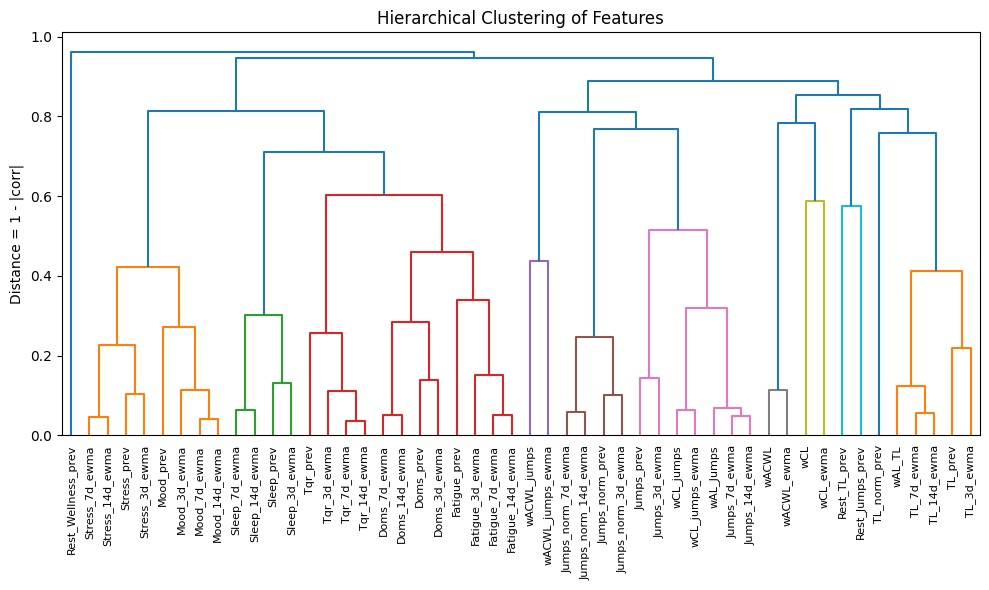

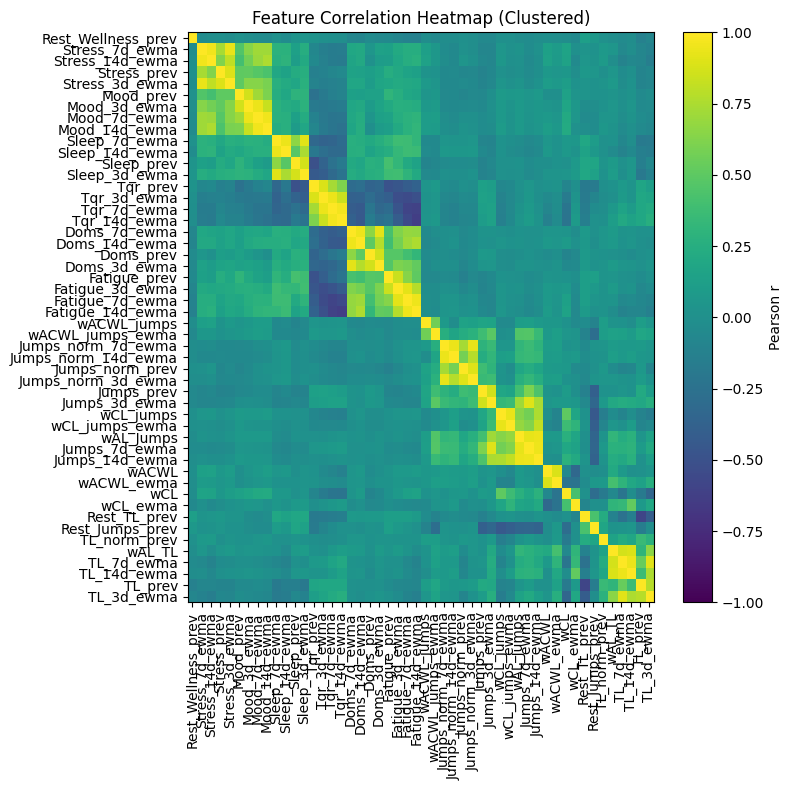

In [ ]:

"""
Using the distance = 1 - |correlation| as the distance metric. Sincce we want to explore
relationships and correlation between features.
"""

# Compute Pearson correlation between features
corr = X_df.corr()

# Create a distance matrix: distance = 1 - |correlation|
dist = 1 - np.abs(corr)

# Condense and cluster
condensed = squareform(dist.values, checks=False)
Z = linkage(condensed, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=feature_cols, leaf_rotation=90)
plt.title('Hierarchical Clustering of Features')
plt.ylabel('Distance = 1 - |corr|')
plt.tight_layout()
plt.show()

# Reorder and plot the correlation heatmap
order = dendrogram(Z, no_plot=True)['leaves']
ordered = corr.iloc[order, order]

plt.figure(figsize=(8, 8))
plt.imshow(ordered, vmin=-1, vmax=1, aspect='auto')
plt.xticks(range(len(order)), [feature_cols[i] for i in order], rotation=90)
plt.yticks(range(len(order)), [feature_cols[i] for i in order])
plt.colorbar(label='Pearson r')
plt.title('Feature Correlation Heatmap (Clustered)')
plt.tight_layout()
plt.show()


Pearsons correlation matrix. Capturing linear dependencies between the features
---



Top positive linear correlations:
TL_norm_prev       0.096292
Doms_14d_ewma      0.057003
Rest_TL_prev       0.043853
wCL_ewma           0.040451
Doms_7d_ewma       0.034059
wCL                0.033463
wCL_jumps_ewma     0.030331
TL_14d_ewma        0.026184
wCL_jumps          0.022482
Rest_Jumps_prev    0.019122
Name: match_perf_weighted, dtype: float64

Top negative linear correlations:
Doms_prev            -0.058902
Jumps_norm_3d_ewma   -0.059744
Sleep_prev           -0.059966
Stress_prev          -0.060300
Jumps_norm_prev      -0.067258
wACWL_ewma           -0.079094
Stress_3d_ewma       -0.081523
Stress_7d_ewma       -0.088035
wACWL                -0.097694
Stress_14d_ewma      -0.107214
Name: match_perf_weighted, dtype: float64


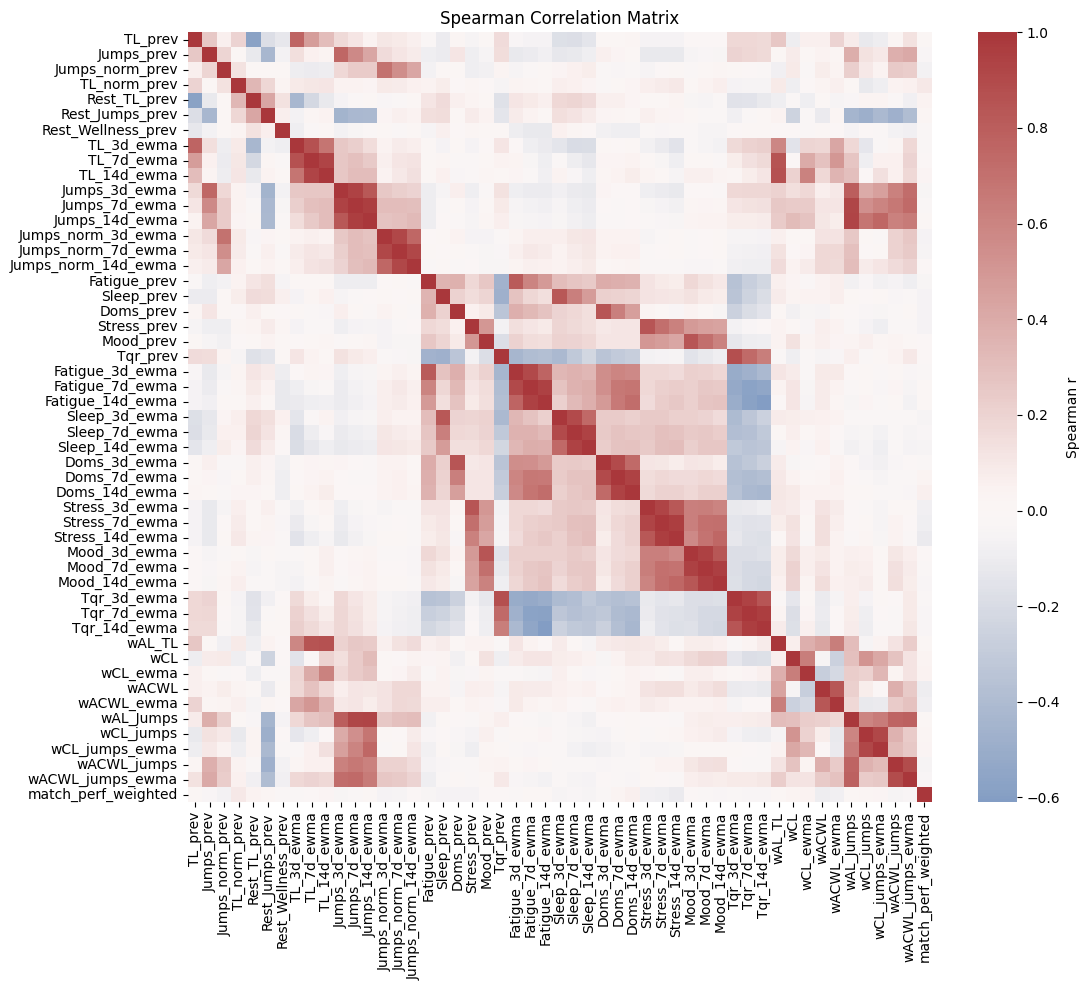

In [ ]:
cols = feature_cols + ["match_perf_weighted"]

# Compute Pearson’s r matrix
spearman_corr = df_matches[cols].corr(method="spearman")

# View the correlation of each feature with performance
perf_lin_corr = spearman_corr["match_perf_weighted"] \
                 .drop("match_perf_weighted") \
                 .sort_values(ascending=False)
print("Top positive linear correlations:")
print(perf_lin_corr.head(10))
print("\nTop negative linear correlations:")
print(perf_lin_corr.tail(10))

# Visualize full matrix as a heatmap

plt.figure(figsize=(12,10))
sns.heatmap(spearman_corr, center=0, cmap="vlag",
            cbar_kws={"label": "Spearman r"})
plt.title("Spearman Correlation Matrix")
plt.show()


Spearman correlations. Capture any monotonic relationships (even if it’s non-linear) and is less distorted by outliers.
---

In [ ]:
# Spearman correlations
# Only compute for columns that were not removed
spearman_scores = {
    col: abs(spearmanr(X_df[col], y)[0])
    for col in X_df.columns
}
spearman_series = pd.Series(spearman_scores).sort_values(ascending=False)
print("Top 10 features by Spearman correlation:")
print(spearman_series.head(10))


Top 10 features by Spearman correlation:
Stress_14d_ewma       0.107214
wACWL                 0.099768
TL_norm_prev          0.096292
Stress_7d_ewma        0.088035
Stress_3d_ewma        0.081523
wACWL_ewma            0.081305
Jumps_norm_prev       0.067258
Stress_prev           0.060300
Sleep_prev            0.059966
Jumps_norm_3d_ewma    0.059744
dtype: float64


PCA analysis
---

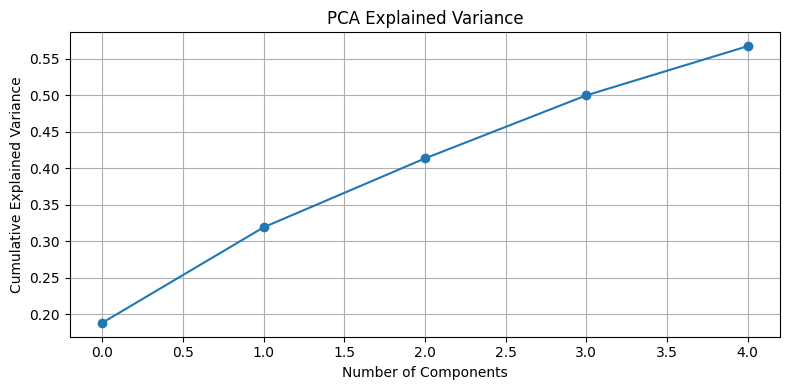

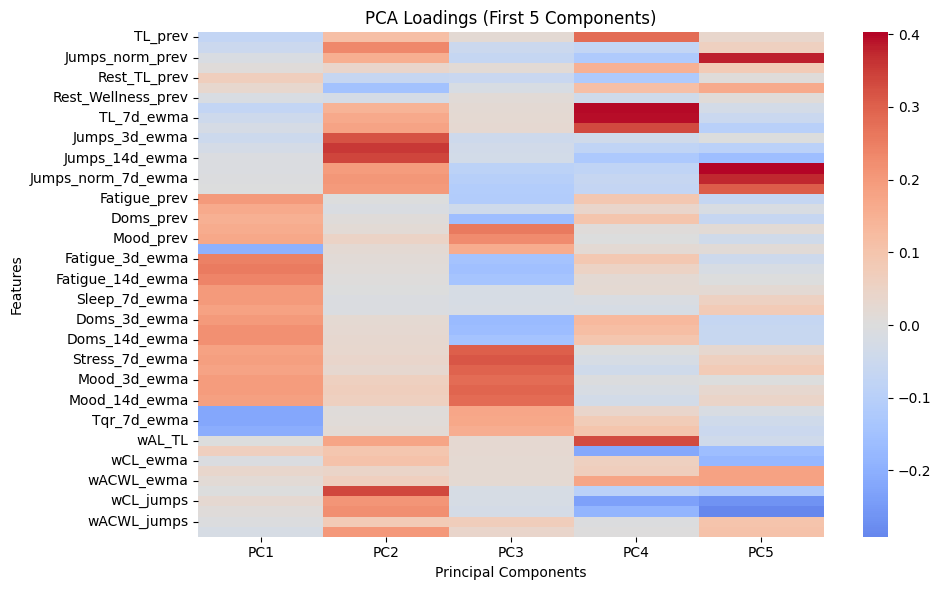

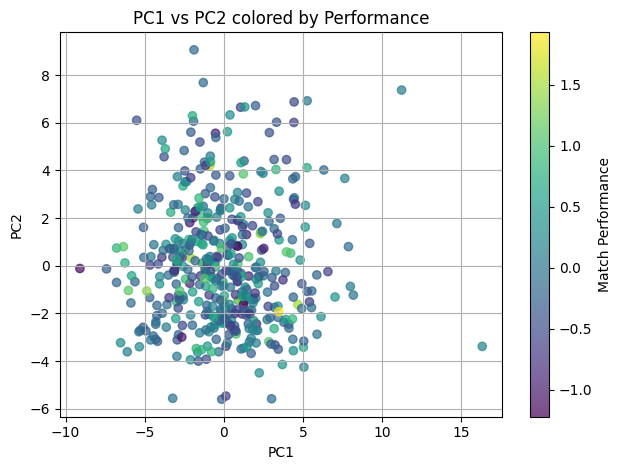

In [ ]:
#  PCA via NumPy SVD
X = X_df.values

# Scale the data to have unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Loadings
loadings = pd.DataFrame(
    pca.components_,
    columns=X_df.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)])


plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.heatmap(loadings.T, cmap="coolwarm", center=0)
plt.title("PCA Loadings (First 5 Components)")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Match Performance')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 colored by Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

PC 1 and PC 2 explain the bulk of variability: they separate recent from acute jump patterns.

PC 4 cleanly isolates medium-term TL, while

PC 5 isolates relative jump deviations.

PC 3 is weak and mixed.

This results suggest to keep PCA 1 & 2, and maybe PCA 4.

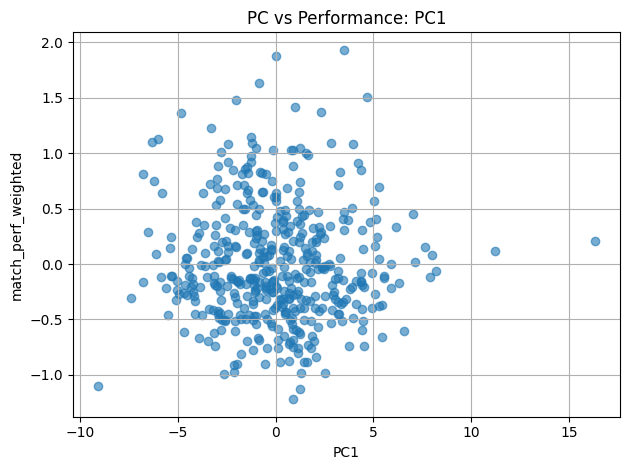

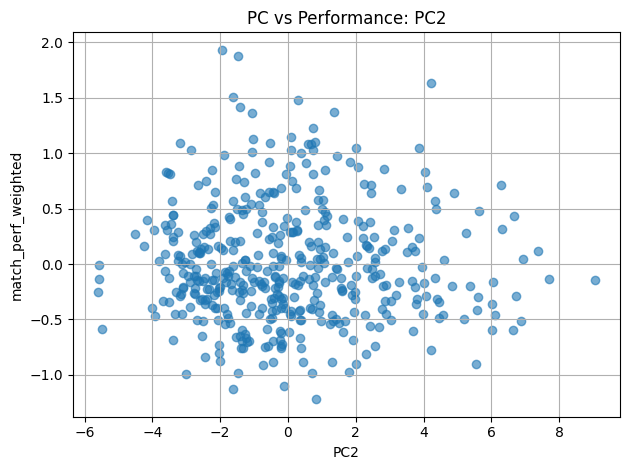

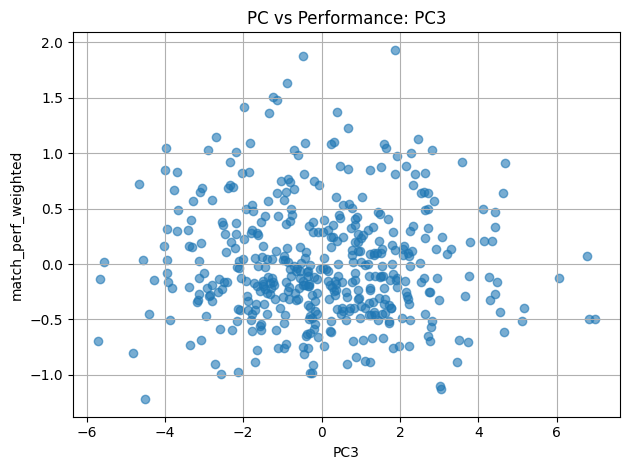

Linear fit on [PC1, PC2] gives R² = 0.001


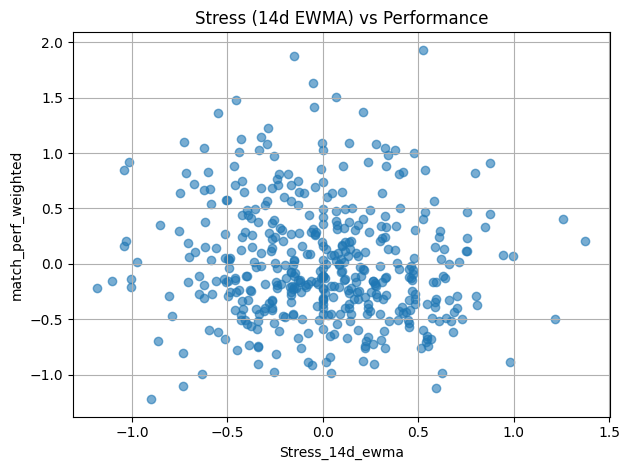

In [ ]:
# Compute PC scores
# pca.components_ is the array of PCA loading vectors (n_components × n_features)
pc_scores = X_scaled.dot(pca.components_.T)    # shape (n_samples, n_components)
pc_df     = pd.DataFrame(
    pc_scores,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=df_matches.index
)

# Scatter PC1–PC3 vs. Performance
for pc in ["PC1", "PC2", "PC3"]:
    plt.figure()
    plt.scatter(pc_df[pc], df_matches["match_perf_weighted"], alpha=0.6)
    plt.xlabel(pc)
    plt.ylabel("match_perf_weighted")
    plt.title(f"PC vs Performance: {pc}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Simple linear regression on PC2 & PC3 with NumPy
y = df_matches["match_perf_weighted"].values
X_reg = np.column_stack([
    np.ones(len(y)),      # intercept
    pc_df["PC1"].values,
    pc_df["PC2"].values
])
# β = (X'X)^(-1) X'y
beta = np.linalg.pinv(X_reg.T @ X_reg) @ (X_reg.T @ y)
y_pred = X_reg @ beta
r2     = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
print(f"Linear fit on [PC1, PC2] gives R² = {r2:.3f}")

# Scatter Stress_14d_ewma vs. Performance
plt.figure()
plt.scatter(df_matches["Stress_14d_ewma"], df_matches["match_perf_weighted"], alpha=0.6)
plt.xlabel("Stress_14d_ewma")
plt.ylabel("match_perf_weighted")
plt.title("Stress (14d EWMA) vs Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

The linear fit on PC2 and PC3 gave R^2 = 0.001. Which means that we cant predict anything with just two components. 99% of the perforamnce is left unexplained. We therefore venture into more advanced linear models, non-linear models and other strategies from here.


# Baseline models
Evaluating different baseline models. Using RMSE and R^2 since we are doing regression. And opting to predict the match_perf_weighted.

RMSE: Average prediction error in the same unit as the target.

R^2: Proportion of variance in the target.

Because match_perf_weighted is continuous, we want metrics that quantify how far off our predictions are from the true continuous values.

In [ ]:
# Build X, y
X = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
y = df_matches['match_perf_weighted'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# investigating feature relevance by purposely overfitting
X_small = X_train[:20]
y_small = y_train[:20]

# Standardize for Elastic Net
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

# ElasticNetCV (mix of L1/L2), good for handling zero or close to zero values.
enet = ElasticNetCV(
    l1_ratio=[0.1,0.5,0.9],
    alphas=np.logspace(-3,1,50),
    cv=5,
    random_state=42,
    max_iter=5000
).fit(Xtr_s, y_train)

# Evaluate
y_pred_enet = enet.predict(Xte_s)
print("ElasticNet R²:", r2_score(y_test, y_pred_enet))
# Calculate RMSE manually if squared=False is not supported
print("ElasticNet RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_enet)))

# Show nonzero coefficients
coef = pd.Series(enet.coef_, index=feature_cols)
print("Top ElasticNet features:\n", coef[coef!=0].abs().sort_values(ascending=False).head(10))


/tmp/ipython-input-3805419489.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values


ElasticNet R²: -0.0036540823975013126
ElasticNet RMSE: 0.5781631354968073
Top ElasticNet features:
 Stress_14d_ewma    0.009785
dtype: float64


IMPORTANT RESULT THAT PROVES THAT THE FEATURES ARE RELEVANT

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np # Import numpy for sqrt

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,      # allow deep trees
    min_samples_leaf=1,  # pure leaves
    random_state=42
)

rf.fit(X_small, y_small)

# Evaluate on the same data (overfitting intentionally)
y_pred = rf.predict(X_small)
r2 = r2_score(y_small, y_pred)
# Calculate RMSE manually by taking the square root of the MSE
rmse = np.sqrt(mean_squared_error(y_small, y_pred))

print(f"Overfit R²: {r2:.3f}")
print(f"Overfit RMSE: {rmse:.3f}")

Overfit R²: 0.859
Overfit RMSE: 0.170


The elasticNet truly reveals the poor performance of linear models on this data.

Random forest (Untuned) below

In [ ]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

# After rf.fit(...)
importances_mdi = pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print("Top RF features by built-in impurity importance:")
print(importances_mdi.head(10))

y_pred_rf = rf.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
# Calculate RMSE manually for Random Forest as well
print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Permutation importance
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
print("Top RF features by permutation importance:\n", imp.head(10))

Top RF features by built-in impurity importance:
Fatigue_prev        0.042508
Stress_3d_ewma      0.037539
Stress_14d_ewma     0.032836
Sleep_14d_ewma      0.031177
wAL_TL              0.029712
wCL                 0.028880
TL_7d_ewma          0.028186
Tqr_7d_ewma         0.027381
Sleep_prev          0.026420
Fatigue_14d_ewma    0.026000
dtype: float64
RandomForest R²: -0.10071064750428027
RandomForest RMSE: 0.6054732394101069
Top RF features by permutation importance:
 Sleep_prev          0.009909
wACWL               0.009528
wCL                 0.006191
Doms_14d_ewma       0.005528
TL_norm_prev        0.004847
Fatigue_14d_ewma    0.003821
TL_prev             0.003699
TL_14d_ewma         0.003278
wCL_jumps           0.003051
Fatigue_3d_ewma     0.002997
dtype: float64


XGBoost (Untuned) below


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

#  Prepare data
X = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_matches['match_perf_weighted']

# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)  # 60/20/20

# Define XGBRegressor with subsampling for speed
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    subsample=0.8,           # row sampling
    colsample_bytree=0.8     # feature sampling
)

# RandomizedSearchCV over a smaller param set & fewer CV folds
param_dist = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 1, 5]
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=12,   # fewer combinations
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


fit_params = {
    "eval_set": [(X_val, y_val)],
    "verbose": False
}

rs.fit(X_train, y_train, **fit_params)


# Evaluate on the test set
best = rs.best_estimator_
y_pred = best.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best parameters (RandomizedSearchCV):", rs.best_params_)
print(f"XGBoost Test R²: {r2:.3f}")
print(f"XGBoost Test RMSE: {rmse:.3f}")

# Feature importances
importances = pd.Series(best.feature_importances_, index=feature_cols)
print("\nTop 10 XGBoost feature importances:")
print(importances.sort_values(ascending=False).head(10))

/tmp/ipython-input-122575445.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = df_matches[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters (RandomizedSearchCV): {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1}
XGBoost Test R²: -0.036
XGBoost Test RMSE: 0.587

Top 10 XGBoost feature importances:
Fatigue_prev       0.030795
TL_3d_ewma         0.025764
Tqr_prev           0.024880
Sleep_prev         0.024449
Jumps_14d_ewma     0.023900
Jumps_7d_ewma      0.023569
Stress_14d_ewma    0.023520
Stress_3d_ewma     0.023051
wAL_Jumps          0.023012
Tqr_14d_ewma       0.022421
dtype: float32


Both models agree that the balance between recent fatigue and training loas is the strongest lever, with jump readiness and wellness markers (stress, DOMS, TQR) playing secondary roles.

Both models perform poorl on the dataset, fluctuating around 0 tells us that they predict close to nothing. Is that our **baseline**?



---

Dimensionality reduction / feature selection
---
We have identified that some feqtures are very similar, and some barely contribute to any predictions. In an attempt to reach higher baseline predictions we trim features. To see if that helps the predicitive power of the models.

In [ ]:
###
# Handpicked via trial and error to maximize the R^2 score. The binary rest flags proved important form performance
strongest_predictors = ['wACWL_ewma', 'TL_norm_prev', 'Jumps_norm_prev', 'Tqr_prev', 'Rest_Jumps_prev' , 'Rest_TL_prev']
# Build X_selected and y
X_sel = df_matches[strongest_predictors].replace([np.inf, -np.inf], np.nan).fillna(0)
y     = df_matches["match_perf_weighted"]

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y, test_size=0.2, random_state=42
)

# Standardize for linear models
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

# ElasticNet on reduced feature set
enet = ElasticNetCV(l1_ratio=[.1, .5, .9], alphas=np.logspace(-3,1,30), cv=5, random_state=42, max_iter=5000)
enet.fit(X_tr_s, y_tr)
y_pred_enet = enet.predict(X_te_s)
print("Reduced EN R²:",   r2_score(y_te, y_pred_enet))
print("Reduced EN RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_enet)))

# Random Forest on reduced feature set
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_te)
print("Reduced RF R²:",   r2_score(y_te, y_pred_rf))
print("Reduced RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_rf)))

# XGBoost on reduced feature set
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_tr, y_tr,
        eval_set=[(X_te, y_te)],
        verbose=False)
y_pred_xgb = xgb.predict(X_te)
print("Reduced XGBoost R²:", r2_score(y_te, y_pred_xgb))
print("Reduced XGBoost RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_xgb)))

Reduced EN R²: 0.003941290653582619
Reduced EN RMSE: 0.5759712924521697


/tmp/ipython-input-4214622006.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_sel = df_matches[strongest_predictors].replace([np.inf, -np.inf], np.nan).fillna(0)


Reduced RF R²: 0.08562654018643467
Reduced RMSE: 0.551848892401916
Reduced XGBoost R²: 0.12873195397070247
Reduced XGBoost RMSE: 0.5386842309297457


Using fewer features made the predicting power of the baseline models better, but still not amazing. XGBoost is the winner with a "whooping"

R²= ~ 12.87%
and RMSE =  ~0.54%

# Temporal Convolution Neural-Network or "TCN"
---


Preparing the time-series window. How long the modell looks back

wACWL_ewma: NaNs in df_flag? False
TL_norm_prev: NaNs in df_flag? False
Jumps_norm_prev: NaNs in df_flag? False
Tqr_prev: NaNs in df_flag? False
Rest_Jumps_prev: NaNs in df_flag? False
Rest_TL_prev: NaNs in df_flag? False
X shape: (446, 5, 40)
y shape: (446,)
Any NaNs in stacked X? False
Any NaNs in y? False
X shape: (446, 5, 40)
X dtype: float32
y shape: (446,)
y dtype: float64
X  global  min/max: -3.0 / 3.0
X  global  mean/std: -0.012569476 / 0.6575136
y  min/max: -1.2192837178666156 / 1.931105071936626
y  mean/std: -0.00013271108020334333 / 0.5240443119847137
Fatigue              min=-3.000  p05=-1.553  p50=-0.047  p95=1.538  max=3.000  std=0.920
Fatigue_prev         min=-3.000  p05=-1.553  p50=-0.047  p95=1.764  max=3.000  std=0.950
Fatigue_3d_ewma      min=-2.367  p05=-1.005  p50=0.065  p95=1.090  max=2.352  std=0.646
Fatigue_7d_ewma      min=-1.809  p05=-0.764  p50=0.063  p95=0.826  max=1.728  std=0.496
Fatigue_14d_ewma     min=-1.433  p05=-0.674  p50=0.062  p95=0.713  max=1.292 

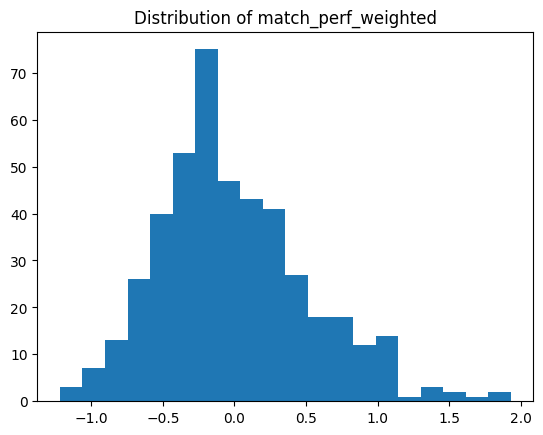

In [ ]:
# Ensure df_flag has no duplicate dates per athlete before creating windows
# This step aggregates any potential duplicate date entries for an athlete
df_flag = (
    df_flag
    .groupby(["Athlete", "Date"], as_index=False)
    .mean() # Use mean to handle potential duplicates; adjust if a different aggregation is needed
)

warnings.filterwarnings("ignore", category=FutureWarning)

# Prepare lists to collect each match’s history + label
X_list, y_list = [], []
window_size = 5 # hyperparameter

# Note, only approproate to use boolean or scaled features.

# Build X_selected and y
#features = [f for f in features_to_clip if f in strongest_predictors] # list of all features taken from the klipping section.
#print(len(features))
features = features_to_clip
for _, row in df_matches.iterrows(): # Loop to use df_matches directly
    athlete    = row["Athlete"]
    match_date = row["Date"]
    perf       = row["match_perf_weighted"]

    # Pull athlete’s full daily record
    df_a = (
        df_flag[df_flag["Athlete"] == athlete]
          .set_index("Date")
          .sort_index()
    )

        # Define the window before match_date, exclusive of the match date
    start    = match_date - pd.Timedelta(days=window_size)
    end_date = match_date - pd.Timedelta(days=1)

    expected_index = pd.date_range(start=start, end=end_date, freq='D')
    window = (
        df_a
        .reindex(expected_index)[features]      # force exactly 7 days
        .ffill()                                # fill forward
        .bfill()                                # fill backward
        .fillna(0)                              # any remaining NaNs → 0
    )

    # Now simply check shape and append
    if window.shape == (window_size, len(features)):
        X_list.append(window.values.astype(np.float32))
        y_list.append(perf)


for f in strongest_predictors:
    print(f"{f}: NaNs in df_flag? {df_flag[f].isna().any()}")

# Stack into arrays
X = np.stack(X_list)    # -> shape (n_samples, window_size, n_channels)
y = np.array(y_list)    # -> shape (n_samples,)

print("X shape:", X.shape)
print("y shape:", y.shape)

print("Any NaNs in stacked X?", np.isnan(X).any())
print("Any NaNs in y?", np.isnan(y).any())

# Basic shapes & dtypes
print("X shape:", X.shape)          # (n_samples, window_size, n_channels)
print("X dtype:", X.dtype)
print("y shape:", y.shape)
print("y dtype:", y.dtype)

# Overall min/max/mean/std
print("X  global  min/max:", X.min(), "/", X.max())
print("X  global  mean/std:", X.mean(), "/", X.std())
print("y  min/max:", y.min(), "/", y.max())
print("y  mean/std:", y.mean(), "/", y.std())

# Per‐channel statistics
for i, feat in enumerate(features):
    arr = X[:, :, i].ravel()  # flatten all samples & days for channel i
    print(f"{feat:20s} min={arr.min():.3f}  p05={np.percentile(arr,5):.3f}  "
          f"p50={np.percentile(arr,50):.3f}  p95={np.percentile(arr,95):.3f}  max={arr.max():.3f}  std={arr.std():.3f}")

# Peek at a single window & its label
print("\nFirst sample (7×n_channels):\n", X[0])
print("First target y[0]:", y[0])

# Distribution plots
import matplotlib.pyplot as plt
plt.hist(y, bins=20)
plt.title("Distribution of match_perf_weighted")
plt.show()


Creating a hold-out test set before building the dataset to ensure we dont touch them during hyperparam tuning.

In [ ]:
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=False       # Want to keep the chronological ordering
)

# Build the TensorDataset for *train+val* only:
X_tv_tensor = torch.tensor(X_tv, dtype=torch.float32)
y_tv_tensor = torch.tensor(y_tv, dtype=torch.float32).unsqueeze(1)
dataset_tv   = TensorDataset(X_tv_tensor, y_tv_tensor)

# Separately prepare the *pure* test tensors for final eval. Putting these away until
# After training
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

Creating the TCN

In [ ]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        # Padding calculation for 'causal' padding to keep length consistent
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size, padding=padding,
                               dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size, padding=padding,
                               dilation=dilation) # Keep channels consistent within block
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        # 1x1 convolution for residual connection if channel sizes don't match
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

        # LayerNorm operates on the last dimension ([B, T, C])
        # Need to permute output from conv ([B, C, T]) before applying
        self.norm = nn.LayerNorm(out_channels)


    def forward(self, x):
        # x: [B, C, T]
        res = x

        out = self.relu(self.conv1(x))
        out = self.dropout1(out)
        out = self.relu(self.conv2(out))
        out = self.dropout2(out)

        # Crop to original length (required for non-causal or asymmetric padding)
        # For causal padding where padding = (k-1)*d, the output length should be T
        # If using padding = (k-1)*d // 2 on both sides, need to crop the end.
        # With padding = (k-1)*d on one side (left/causal), crop from the right.
        out = out[:, :, :res.size(2)]

        # Residual connection
        if self.downsample is not None:
            res = self.downsample(res)

        out = out + res

        # Layer normalization (requires [B, T, C])
        out = out.permute(0,2,1)
        out = self.norm(out)
        out = out.permute(0,2,1) # Back to [B, C, T] for the next block

        return out


# Define the full TCN model

class TCNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, dilations, dropout, window_size):
        super().__init__()
        layers = []
        num_dilations = len(dilations)
        # Initial conv layer to map input channels to hidden channels
        layers.append(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1)
        )
        layers.append(nn.ReLU())

        # TCN blocks
        for i in range(num_dilations):
             dilation = dilations[i]
             in_c = hidden_channels # All blocks operate on hidden_channels after initial conv
             out_c = hidden_channels
             layers.append(TCNBlock(in_c, out_c, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)

        self.flatten = nn.Flatten()
        # The input to the FC layer is the output of the last TCN block
        # which has hidden_channels * window_size features
        self.fc1 = nn.Linear(hidden_channels * window_size, 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        # x: [B, T, C_in] -> permute to [B, C_in, T]
        x = x.permute(0,2,1) # [B, C_in, T]
        x = self.tcn(x)      # Output: [B, C_hidden, T]
        x = x.permute(0,2,1) # Back to [B, T, C_hidden]
        x = self.flatten(x)  # [B, T * C_hidden]
        x = self.relu(self.fc1(x))
        return self.out(x)




Optuna hyperparameter tuning of the TCN

In [ ]:
# Optuna objective: use dataset_tv and k-fold or fresh splits

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size= X_tv.shape[1]
n_channels = X_tv.shape[2]

def objective(trial):
    # Suggest hyperparams
    hidden_channels = trial.suggest_categorical("hidden_channels",[2, 3, 4, 8])
    kernel_size     = trial.suggest_categorical("kernel_size",[2, 3, 4])
    num_dilations   = trial.suggest_int("num_dilations", 1, 2)
    dilations       = [2**i for i in range(num_dilations)]
    dropout_rate    = trial.suggest_float("dropout",0.5, 0.7)
    lr              = trial.suggest_loguniform("lr",1e-5, 1e-1)
    wd              = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)

    # Model + optimizer
    model = TCNRegressor(
        in_channels=n_channels,
        hidden_channels=hidden_channels,
        kernel_size=kernel_size,
        dilations=dilations,
        dropout=dropout_rate,
        window_size=window_size # Correctly passing window_size here
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()

    # Train/val split *inside* trial for fresh randomness or k-fold
    # Here: simple random split on dataset_tv
    n = len(dataset_tv)
    n_train = int(0.8*n)
    train_ds, val_ds = random_split(
        dataset_tv,
        [n_train, n-n_train],
        generator=torch.Generator().manual_seed(42)
    )
    train_loader = DataLoader(train_ds, batch_size=16,
                              shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=16,
                              shuffle=False)

    # Train with early stopping
    best_val_loss = np.inf
    best_val_r2   = -np.inf
    patience, wait = 1, 0
    # Added model_path to save the best model state
    model_path = "tcn_best_trial.pt" # Save best model for this trial

    for epoch in range(1,300):
        model.train()
        for xb,yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward(); optimizer.step()

        # validation
        model.eval()
        val_losses, preds, trues = [], [], []
        with torch.no_grad():
            for xb,yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                val_losses.append(criterion(out,yb).item())
                preds.append(out.cpu().numpy()); trues.append(yb.cpu().numpy())

        val_mse = np.mean(val_losses)
        val_r2  = r2_score(np.vstack(trues), np.vstack(preds))

        trial.report(val_r2, epoch)
        if trial.should_prune():  # allow Optuna to prune bad trials
            raise optuna.exceptions.TrialPruned()

        # early stop - save best R2
        if val_r2 > best_val_r2:
              best_val_r2 = val_r2
              wait = 0
              torch.save(model.state_dict(), model_path)
        else:
            wait += 1
            if wait >= patience:
                break

    # storing MSE aswell
    trial.set_user_attr("best_val_mse", val_mse)

    # Load the best model state dict for this trial before returning the loss
    model.load_state_dict(torch.load(model_path, map_location=device))

    return best_val_r2

Running the Optuna study and retraining the model with the best hyperparameters.

In [ ]:

warnings.filterwarnings("ignore", category=FutureWarning)
# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=3600)

print("Best val R²:", study.best_value)
print("Best params:", study.best_params)
print("Best val MSE:", study.best_trial.user_attrs["best_val_mse"])

# Rerun with best hyperparams

best_hp = study.best_params
# Rebuild & train the single “final” model on all of train+val:
final_model = TCNRegressor(
    in_channels=n_channels,
    hidden_channels=best_hp["hidden_channels"],
    kernel_size=best_hp["kernel_size"],
    dilations=[2**i for i in range(best_hp["num_dilations"])],
    dropout=best_hp["dropout"],
    window_size=window_size
).to(device)

# Define optimizer and loss for the final training run
final_optimizer = torch.optim.AdamW(final_model.parameters(),
                                    lr=best_hp["lr"],
                                    weight_decay=best_hp["weight_decay"])
final_criterion = nn.MSELoss()

[I 2025-08-15 09:25:53,465] A new study created in memory with name: no-name-aae669ec-4193-4a4e-ab0d-90985dd6a9ea
[I 2025-08-15 09:25:58,572] Trial 0 finished with value: 0.01960766315460205 and parameters: {'hidden_channels': 8, 'kernel_size': 4, 'num_dilations': 1, 'dropout': 0.6588669022536087, 'lr': 0.01319236355359779, 'weight_decay': 2.6615152616634904e-05}. Best is trial 0 with value: 0.01960766315460205.
[I 2025-08-15 09:25:58,823] Trial 1 finished with value: -0.09742152690887451 and parameters: {'hidden_channels': 4, 'kernel_size': 3, 'num_dilations': 1, 'dropout': 0.6327193804128547, 'lr': 0.00905862301988426, 'weight_decay': 2.648981253902021e-06}. Best is trial 0 with value: 0.01960766315460205.
[I 2025-08-15 09:25:59,928] Trial 2 finished with value: -0.0430828332901001 and parameters: {'hidden_channels': 4, 'kernel_size': 4, 'num_dilations': 1, 'dropout': 0.6467432142660781, 'lr': 3.603145422401677e-05, 'weight_decay': 5.671584649910532e-06}. Best is trial 0 with value: 

Best val R²: 0.09726792573928833
Best params: {'hidden_channels': 8, 'kernel_size': 4, 'num_dilations': 2, 'dropout': 0.5308051947206995, 'lr': 0.0014879812230520343, 'weight_decay': 4.3908496741350615e-05}
Best val MSE: 0.2659623950719833


Validating the r^2 performance

Epoch 10: train R²=0.495, val R²=-0.332
Epoch 20: train R²=0.844, val R²=-0.650
Epoch 30: train R²=0.936, val R²=-0.839
Epoch 40: train R²=0.982, val R²=-0.879
Epoch 50: train R²=0.994, val R²=-0.898
Epoch 60: train R²=0.991, val R²=-0.939
Epoch 70: train R²=0.974, val R²=-0.954
Epoch 80: train R²=0.998, val R²=-0.938
Epoch 90: train R²=0.986, val R²=-0.939
Epoch 100: train R²=0.995, val R²=-0.990
Epoch 110: train R²=0.995, val R²=-0.967
Epoch 120: train R²=0.994, val R²=-0.909
Epoch 130: train R²=0.984, val R²=-0.869
Epoch 140: train R²=0.987, val R²=-0.926
Epoch 150: train R²=0.994, val R²=-0.951
Epoch 160: train R²=0.994, val R²=-0.894
Epoch 170: train R²=0.996, val R²=-0.850
Epoch 180: train R²=0.997, val R²=-0.888
Epoch 190: train R²=0.990, val R²=-0.876
Epoch 200: train R²=0.964, val R²=-0.861
Epoch 210: train R²=0.995, val R²=-0.903
Epoch 220: train R²=0.999, val R²=-0.858
Epoch 230: train R²=0.999, val R²=-0.872
Epoch 240: train R²=0.998, val R²=-0.845
Epoch 250: train R²=0.990

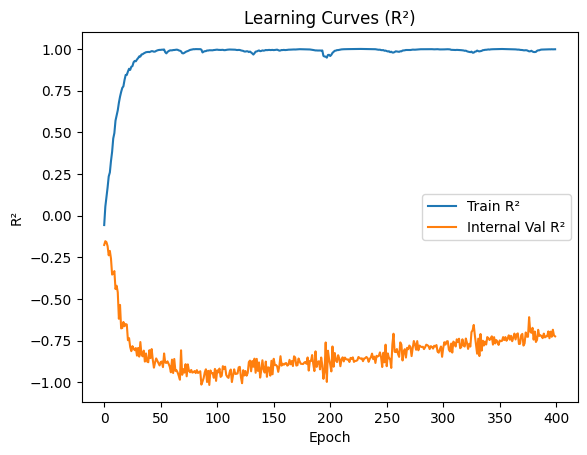

In [ ]:
# carve out an internal val split from dataset_tv
n_tv     = len(dataset_tv)
n_train  = int(0.8 * n_tv)
train_int, val_int = random_split(
    dataset_tv,
    [n_train, n_tv - n_train],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_int, batch_size=16, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_int,   batch_size=16, shuffle=False, drop_last=False)

train_r2, val_r2 = [], []

for epoch in range(1, 400 + 1):
    # — train —
    final_model.train()
    preds_tr, trues_tr = [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        final_optimizer.zero_grad()
        out = final_model(xb)
        loss = final_criterion(out, yb)
        loss.backward()
        final_optimizer.step()
        preds_tr.append(out.detach().cpu().numpy())
        trues_tr.append(yb.cpu().numpy())
    train_r2.append(r2_score(np.vstack(trues_tr), np.vstack(preds_tr)))

    # — validate —
    final_model.eval()
    preds_va, trues_va = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = final_model(xb)
            preds_va.append(out.cpu().numpy())
            trues_va.append(yb.cpu().numpy())
    val_r2.append(r2_score(np.vstack(trues_va), np.vstack(preds_va)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: train R²={train_r2[-1]:.3f}, val R²={val_r2[-1]:.3f}")

# Plot the curves
plt.plot(train_r2, label="Train R²")
plt.plot(val_r2,   label="Internal Val R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.legend()
plt.title("Learning Curves (R²)")
plt.show()


Final training loop on the held out dataset.

In [ ]:
# DataLoader for the full train+val dataset
final_train_loader = DataLoader(dataset_tv, batch_size=16, shuffle=True, drop_last=True)

# Final training loop
epochs_final = 200 #hyperparam
for epoch in range(1, epochs_final + 1):
    final_model.train()
    total_loss = 0
    for xb, yb in final_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        final_optimizer.zero_grad()
        loss = final_criterion(final_model(xb), yb)
        loss.backward()
        final_optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_final}, Train Loss: {total_loss / len(final_train_loader):.4f}")

# Now evaluate the final_best_model on the pure test set
final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor.to(device)).cpu().numpy()

test_rmse = np.sqrt(mean_squared_error(y_test, preds))
test_r2   = r2_score(y_test, preds)

print(f"\nFinal Model Test  RMSE: {test_rmse:.3f}")
print(f"Final Model Test  R²:   {test_r2:.3f}")

Epoch 10/200, Train Loss: 0.0085
Epoch 20/200, Train Loss: 0.0032
Epoch 30/200, Train Loss: 0.0016
Epoch 40/200, Train Loss: 0.0006
Epoch 50/200, Train Loss: 0.0017
Epoch 60/200, Train Loss: 0.0019
Epoch 70/200, Train Loss: 0.0024
Epoch 80/200, Train Loss: 0.0030
Epoch 90/200, Train Loss: 0.0028
Epoch 100/200, Train Loss: 0.0006
Epoch 110/200, Train Loss: 0.0011
Epoch 120/200, Train Loss: 0.0034
Epoch 130/200, Train Loss: 0.0036
Epoch 140/200, Train Loss: 0.0006
Epoch 150/200, Train Loss: 0.0010
Epoch 160/200, Train Loss: 0.0030
Epoch 170/200, Train Loss: 0.0020
Epoch 180/200, Train Loss: 0.0012
Epoch 190/200, Train Loss: 0.0012
Epoch 200/200, Train Loss: 0.0030

Final Model Test  RMSE: 0.663
Final Model Test  R²:   -0.973


The dataset is probably to small. From here we could try other models, generate syntethic data, or realize that we need better/more data in order to predict anything of value. ALternatively change strategies altogether.